In [2]:
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt 
from multiprocessing import Pool
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [3]:
### read census tract geometry
census_tracts_gdf = gpd.read_file('traffic_inputs/census_tract.geojson')
census_tracts_gdf = census_tracts_gdf.to_crs(4326)
ba_census_tracts_gdf = census_tracts_gdf.loc[census_tracts_gdf['COUNTY'].isin(['001', '013', '041', '055', '075', '081', '085', '095', '097'])].copy().reset_index()
print(ba_census_tracts_gdf.shape)
ba_census_tracts_gdf.head(2)

(1585, 9)


,index,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry
0,0,1400000US06001425103,06,001,425103,4251.03,Tract,0.341,"MULTIPOLYGON (((-122.29236 37.84936, -122.2895..."
1,1,1400000US06001425104,06,001,425104,4251.04,Tract,0.415,"MULTIPOLYGON (((-122.27860 37.82854, -122.2780..."


In [5]:
### building
building_df = pd.read_csv('BayArea-Buildings-Damage.csv')
building_gdf = gpd.GeoDataFrame(building_df, crs=4326, geometry=[Point(xy) for xy in zip(building_df.longitude, building_df.latitude)])
building_gdf.head(2)

,id,longitude,latitude,stories,yearbuilt,occupancy,structure,areafootprint,simID,RedTagged,geometry
0,9794592,-122.495052,37.716307,1,1948,RES1,W1,90.423164,1,0.0,POINT (-122.49505 37.71631)
1,9794593,-122.478313,37.716702,1,1947,RES1,W1,187.357970,2,0.0,POINT (-122.47831 37.71670)


In [6]:
def building_damage_ratio(tract_info):
    [tract_id, tract_geom] = tract_info
    coarse_match_ids = list(building_sindex.intersection(tract_geom.bounds))
    coarse_matchs = building_gdf.iloc[coarse_match_ids]
    precise_matches = coarse_matchs[coarse_matchs.intersects(tract_geom)]
#     print(tract_id)
    return (tract_id, np.sum(precise_matches['RedTagged']==1), precise_matches.shape[0])

building_sindex = building_gdf.sindex
print('finish spatial indexing')
pool = Pool(processes=30)
tract_info_list = ba_census_tracts_gdf[['GEO_ID', 'geometry']].values.tolist()
res = pool.imap_unordered(building_damage_ratio, tract_info_list)
pool.close()
pool.join()

tract_building_damage_list = [(tract_id, damaged, total) for (tract_id, damaged, total) in res]
tract_building_damage_df = pd.DataFrame(tract_building_damage_list, columns=['GEO_ID', 'damaged_building', 'total_building'])
tract_building_damage_df.head(2)

finish spatial indexing


,GEO_ID,damaged_building,total_building
0,1400000US06001437702,0,360
1,1400000US06001425103,4,331


In [7]:
### pipe_nodes
pipe_gdf = gpd.read_file('lack_demand_nodes.geojson')
pipe_gdf.head(2)

,node_id,head,supply,leak_discharge,longitude,latitude,elevation,demand,MM_2018_gp,ave_deficiencies,geometry
0,29057,30.246546,0.994697,0.0,-122.106105,37.678483,61.81,0.0,1.317115,8.375918,POINT (-122.10611 37.67848)
1,29058,30.246546,0.186506,0.0,-122.106095,37.678486,61.81,0.0,0.246959,8.375917,POINT (-122.10610 37.67849)


In [8]:
def pipe_damage_cnt(tract_info):
    [tract_id, tract_geom] = tract_info
    coarse_match_ids = list(pipe_sindex.intersection(tract_geom.bounds))
    coarse_matchs = pipe_gdf.iloc[coarse_match_ids]
    precise_matches = coarse_matchs[coarse_matchs.intersects(tract_geom)]
    return (tract_id, precise_matches.shape[0])

pipe_sindex = pipe_gdf.sindex
print('finish spatial indexing')
pool = Pool(processes=4)
tract_info_list = ba_census_tracts_gdf[['GEO_ID', 'geometry']].values.tolist()
res = pool.imap_unordered(pipe_damage_cnt, tract_info_list)
pool.close()
pool.join()

tract_pipe_damage_list = [(tract_id, damaged) for (tract_id, damaged) in res]
tract_pipe_damage_df = pd.DataFrame(tract_pipe_damage_list, columns=['GEO_ID', 'damaged_pipe_cnts'])
tract_pipe_damage_df.head(2)

finish spatial indexing


,GEO_ID,damaged_pipe_cnts
0,1400000US06001425103,0
1,1400000US06001427100,0


In [9]:
### read commute data
commute_data = pd.read_csv('traffic_inputs/commute_data.csv')
commute_data.head()

### filter to those within Bay Area
ba_census_tracts_gdf['FIPS'] = ba_census_tracts_gdf['GEO_ID'].apply(lambda x: int(x.split('US')[1]))
ba_commute_data = commute_data.loc[(
    commute_data['OFIPS'].isin(ba_census_tracts_gdf['FIPS'])) & (
    commute_data['DFIPS'].isin(ba_census_tracts_gdf['FIPS']))].reset_index()
print(commute_data.shape, ba_commute_data.shape)
print('bay area has {} census tracts, but only {}/{} census tract level OD pairs, {} trips'.format(
    ba_census_tracts_gdf.shape, len(np.unique(ba_commute_data['OFIPS'])), len(np.unique(ba_commute_data['DFIPS'])), np.sum(ba_commute_data['FLOW'])))
ba_commute_data.head(2)

(4155548, 12) (109115, 13)
bay area has (1585, 10) census tracts, but only 1577/1578 census tract level OD pairs, 3296835 trips


,index,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,LENKM,ESTDIVMOE
0,70,6055201700,6055201700,6,55,201700,6,55,201700,2020,427,0.0,4.73
1,92,6075061500,6075061500,6,75,61500,6,75,61500,1775,318,0.0,5.58


,OFIPS,DFIPS,FLOW,FIPS_O,damage_ratio_O,FIPS_D,damage_ratio_D,flow_n,flow_c,flow_hc,diff,diff_ratio
0,6055201700,6055201700,2020,6055201700,0.0,6055201700,0.0,2020,2020,2020,0,0.0
1,6075061500,6075061500,1775,6075061500,0.0,6075061500,0.0,1775,1775,1775,0,0.0
2,6081613700,6081613700,1330,6081613700,0.0,6081613700,0.0,1330,1330,1330,0,0.0
3,6085513000,6085513000,1265,6085513000,0.0,6085513000,0.0,1265,1265,1265,0,0.0
4,6075061500,6075011700,1065,6075061500,0.0,6075011700,0.0,1065,1065,1065,0,0.0


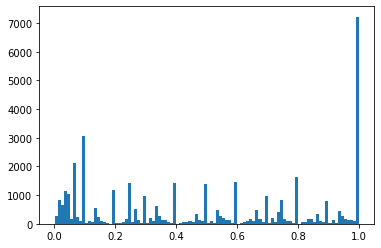

(109115, 12) 3296835 2793326 3008706


In [10]:
### After damage
damaged_tract_data = ba_census_tracts_gdf.merge(tract_building_damage_df, how='left', on='GEO_ID').merge(tract_pipe_damage_df, how='left', on='GEO_ID')
damaged_tract_data['damage_ratio'] = (damaged_tract_data['damaged_building'] + damaged_tract_data['damaged_pipe_cnts']*2)/damaged_tract_data['total_building']
damaged_tract_data['damage_ratio'] = np.where(damaged_tract_data['damage_ratio']>1, 1, damaged_tract_data['damage_ratio'])
# display(damaged_tract_data.head())

damaged_commute_data = ba_commute_data[['OFIPS', 'DFIPS', 'FLOW']].copy()
damaged_commute_data = damaged_commute_data.merge(
    damaged_tract_data[['FIPS', 'damage_ratio']], how='left', left_on='OFIPS', right_on='FIPS').merge(
    damaged_tract_data[['FIPS', 'damage_ratio']], how='left', left_on='DFIPS', right_on='FIPS', suffixes=['_O', '_D'])

damaged_commute_data['flow_n'] = damaged_commute_data['FLOW']
damaged_commute_data['flow_c'] = damaged_commute_data['FLOW'] * (1-damaged_commute_data['damage_ratio_O']) * (1-damaged_commute_data['damage_ratio_D'])
damaged_commute_data['flow_c'] = damaged_commute_data['flow_c'].astype(int)
damaged_commute_data['flow_hc'] = damaged_commute_data['FLOW'] * (1-0.5*damaged_commute_data['damage_ratio_O']) * (1-0.5*damaged_commute_data['damage_ratio_D'])
damaged_commute_data['flow_hc'] = damaged_commute_data['flow_hc'].astype(int)
damaged_commute_data['diff'] = damaged_commute_data['flow_n']-damaged_commute_data['flow_c']
damaged_commute_data['diff_ratio'] = damaged_commute_data['diff'] / damaged_commute_data['flow_n']
display(damaged_commute_data.head())
plt.hist(damaged_commute_data.loc[damaged_commute_data['diff_ratio']>-0.0, 'diff_ratio'], bins=100)
plt.show()
print(damaged_commute_data.shape, np.sum(damaged_commute_data['flow_n']), np.sum(damaged_commute_data['flow_c']), np.sum(damaged_commute_data['flow_hc']))
# print((damaged_commute_data['FLOW']-damaged_commute_data['FLOW_remaining']).describe())

In [11]:
ba_tracts_centroid_gdf = ba_census_tracts_gdf.copy()
ba_tracts_centroid_gdf['c_x'] = ba_census_tracts_gdf['geometry'].centroid.x
ba_tracts_centroid_gdf['c_y'] = ba_census_tracts_gdf['geometry'].centroid.y

damaged_commute_data_geom = damaged_commute_data[['OFIPS', 'DFIPS', 'flow_n', 'flow_c', 'flow_hc']].copy().merge(
    ba_tracts_centroid_gdf[['FIPS', 'c_x', 'c_y']], how='left', left_on='OFIPS', right_on='FIPS').merge(
    ba_tracts_centroid_gdf[['FIPS', 'c_x', 'c_y']], how='left', left_on='DFIPS', right_on='FIPS', suffixes=['_O', '_D'])
damaged_commute_data_geom['geometry'] = damaged_commute_data_geom.apply(lambda x: 'LINESTRING ({} {}, {} {})'.format(x['c_x_O'], x['c_y_O'], x['c_x_D'], x['c_y_D']), axis=1)
damaged_commute_data_geom[['OFIPS', 'DFIPS', 'flow_n', 'flow_c', 'flow_hc', 'geometry']].to_csv('commute_flow_pattern.csv', index=False)


In [12]:
### Find nodes inside each tract
def nodes_in_tract(tract_info):
    [tract_id, tract_geom] = tract_info
    coarse_match_ids = list(nodes_sindex.intersection(tract_geom.bounds))
    coarse_matchs = nodes_gdf.iloc[coarse_match_ids]
    precise_matches = coarse_matchs[coarse_matchs.intersects(tract_geom)]
    return (tract_id, precise_matches['osmid'].values.tolist())

nodes_df = pd.read_csv('../network_inputs/unique_id_nodes.csv')
display(nodes_df.head())
nodes_gdf = gpd.GeoDataFrame(nodes_df, crs=4326, geometry=[Point(xy) for xy in zip(nodes_df.lon, nodes_df.lat)])
nodes_sindex = nodes_gdf.sindex
print('finish spatial indexing')
pool = Pool(processes=30)
tract_info_list = ba_census_tracts_gdf[['FIPS', 'geometry']].values.tolist()
res = pool.imap_unordered(nodes_in_tract, tract_info_list)
pool.close()
pool.join()

tract_nodes_dict = {tract_id: nodes_list for (tract_id, nodes_list) in res}
print(len([i for v in tract_nodes_dict.values() for i in v]), nodes_gdf.shape)

,node_id_igraph,osmid,lon,lat
0,0,56098817,-122.769449,38.435336
1,1,65536002,-122.136780,37.407134
2,2,56098819,-122.769268,38.433763
3,3,1919942662,-121.972040,38.014768
4,4,65536007,-121.778356,37.325199


finish spatial indexing
209515 (224223, 5)


In [16]:
### tract-to-tract OD to node-to-node OD
def chunks(l, div):
    # Yield successive n-sized chunks from l.
    n = int(np.ceil(len(l)/div))
    for i in range(0, len(l), n):
        yield l[i:i + n]

display(damaged_commute_data[['OFIPS', 'DFIPS', 'flow_n', 'flow_c', 'flow_hc']].head(2))
print('total OD pairs before {}, after {}, half repaired {}'.format(np.sum(damaged_commute_data['flow_n']), np.sum(damaged_commute_data['flow_c']), np.sum(damaged_commute_data['flow_hc'])))

for scenario in ['n', 'c', 'hc']:
    node_od_list = []
    unsuccessful_od = []
    for tract_od in damaged_commute_data.itertuples():
        origin_tract = int(getattr(tract_od, 'OFIPS'))
        destin_tract = int(getattr(tract_od, 'DFIPS'))
        tract_od_flow = int(getattr(tract_od, 'flow_{}'.format(scenario)))
        try:
            node_o = random.choices(tract_nodes_dict[origin_tract], k=tract_od_flow)
            node_d = random.choices(tract_nodes_dict[destin_tract], k=tract_od_flow)
            node_od_list += list(zip(node_o, node_d))
        except KeyError:
            print(origin_tract, destin_tract, tract_od_flow)
            unsuccessful_od.append((origin_tract, destin_tract))
        except IndexError:
            unsuccessful_od.append((origin_tract, destin_tract))
    random.shuffle(node_od_list)
    print('Scenario {}: {} out of {} tract OD failed to match to nodes'.format(scenario, len(unsuccessful_od), damaged_commute_data.shape[0]))

    div_node_od_super_list = list(chunks(node_od_list, 3))
    chunk_num = 0
    agent_id_shift = 0
    for div_node_od_list in div_node_od_super_list:
        div_node_od_df = pd.DataFrame(div_node_od_list, columns=['O', 'D'])
        div_node_od_df['agent_id'] = agent_id_shift
        div_node_od_df['agent_id'] += range(div_node_od_df.shape[0])
        agent_id_shift += div_node_od_df.shape[0]
        div_node_od_df[['agent_id', 'O', 'D']].to_csv('od_{}_{}.csv'.format(scenario, chunk_num), index=False)
        chunk_num += 1

,OFIPS,DFIPS,flow_n,flow_c,flow_hc
0,6055201700,6055201700,2020,2020,2020
1,6075061500,6075061500,1775,1775,1775


total OD pairs before 3296835, after 2793326, half repaired 3008706
Scenario n: 25 out of 109115 tract OD failed to match to nodes


KeyboardInterrupt: 